In [1]:
import os
#comment out below if you switch to the CPU only mode
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
print(tf.__version__)
# Print list of all available physical devices (including GPUs)
physical_devices = tf.config.list_physical_devices()
print("Available Physical Devices:", physical_devices)

# Print list of all available logical devices
logical_devices = tf.config.list_logical_devices()
print("Available Logical Devices:", logical_devices)

# Check if GPU is available
gpu_available = tf.config.experimental.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available and recognized by TensorFlow.")
else:
    print("No GPU is available or TensorFlow doesn't recognize the GPU.")

2.10.0
Available Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available Logical Devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU is available and recognized by TensorFlow.


In [2]:
import sys
sys.path.append("C:/Users/Unknown/Documents/VSCode/Jupyter")
from image_eval import psnr,ssim,msssim,Perceptual_loss,blinds_ii,calculate_vif,loss_fn_alex,Ds,psnr_hvs,tensor_reshaper
import tensorflow as tf
print(tf.__version__)
import numpy as np
import cv2,os,math,keras,torch,time
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as K
data_size = 960
x_test = np.load(f'C:/Users/Unknown/Documents/VSCode/Jupyter/Validation{data_size}_half.npy')
output_size=640,640
def imresize(array,shape):
    resized_images = np.empty((array.shape[0], shape, shape), dtype=array.dtype)
    for i in range(array.shape[0]):
        # Extract the current image
        current_image = array[i, :, :]  # Assuming the channel axis is the last one
        # Resize the image using cv2.resize
        resized_image = cv2.resize(current_image, (shape, shape), interpolation=cv2.INTER_LINEAR)
        # Add the resized image to the new array
        resized_images[i, :, :] = resized_image
    return resized_images

resize=1
if resize:
    shape=output_size[0]
    x_test=imresize(x_test,shape)
x_test=tf.image.convert_image_dtype(x_test,dtype='float16')#do not use bfloat16. it is only for TPU and AVX-512 for now.

#plt.imshow(tf.cast(x_test[0],dtype='float32'))
x_test = tf.expand_dims(x_test, axis=-1)
#confirm they are idential except N
print(x_test.shape)
print(x_test.dtype)

def PropagationLayer(input,mode=None):#Angular spectrum method for input or output
    input=tf.cast(input,dtype='float32')#estimated POH itself
    inputs=Input((output_size[0],output_size[1],1))
    input=tf.squeeze(input, axis=-1)#to eliminate calculation error in ASM
    lamda = 532e-9 #lambda is the reserved word
    dp = 8e-6 #pixel size of SLM you use
    z = 100e-3 #propagation distance you assume
    pad_m = inputs.shape[1] // 2
    pad_n = inputs.shape[2] // 2
    if mode=="input":
        padded_real = tf.math.cos(input)
        padded_imaginary = tf.math.sin(input)
        z = -z #propagation distance,bu reverse direction
    else: #input is 0 to 1 data by sigmoid
        padded_real = tf.math.cos(2*math.pi*input)
        padded_imaginary = tf.math.sin(2*math.pi*input)
    inputsc = tf.complex(padded_real, padded_imaginary)#complex amp of POH, same as exp(1j*...)
    Lx = dp * inputs.shape[2]
    Ly = dp * inputs.shape[1]
    f_max = 0.5 / dp
    du = 1.0 / Lx
    dv = 1.0 / Ly
    x_range = tf.range(-f_max, f_max, du, dtype=tf.float32)
    y_range = tf.range(-f_max, f_max, dv, dtype=tf.float32)
    fx, fy = tf.meshgrid(x_range, y_range)
    FH = tf.signal.fftshift(tf.signal.ifft2d(tf.signal.fftshift(inputsc)))
    real_part = tf.math.cos(2 * math.pi * z * tf.sqrt(1 /(lamda**2) - fx**2 - fy**2))
    imaginary_part = tf.math.sin(2 * math.pi * z * tf.sqrt(1 /(lamda**2) - fx**2 - fy**2))
    P = tf.complex(real_part, imaginary_part)#normal ASM kernel
    #define frequency limit for sampling theorem
    fx_max = tf.math.divide(inputs.shape[1] * dp, lamda * tf.math.sqrt((2 * z) ** 2 + (inputs.shape[1]  * dp) ** 2))
    fy_max = tf.math.divide(inputs.shape[2] * dp, lamda * tf.math.sqrt((2 * z) ** 2 + (inputs.shape[2]  * dp) ** 2))
    P = tf.where(tf.math.logical_and(tf.abs(fx) < fx_max, tf.abs(fy) < fy_max), x=P, y=0.0)#band-limiting mask for kernal(sampling theorem)

    P = tf.expand_dims(P, axis=0)  # Add a batch dimension
    U = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(FH * P)))#kernel applied in Fourier domain
    if mode=="input":
        U = tf.expand_dims(U, axis=-1)
        asm = tf.concat([tf.math.real(U), tf.math.imag(U)], axis=-1)#complex amp
    else:
        asm = tf.square(tf.abs(U)) #observed info
    return asm

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Unknown\Documents\VSCode\Jupyter\.venv\lib\site-packages\lpips\weights\v0.1\alex.pth
2.10.0
(50, 640, 640, 1)
<dtype: 'float16'>


You can use either dynamic batch size with single input loop, or static batch size without loop.
Dynamic batch size without loop won't work somehow, I recommend to use static one in terms of speed. 
Althogh you have realtime task, specifying 1 as batch size then making it loop seems rational.

In [10]:
#!python -m onnxruntime.tools.make_dynamic_shape_fixed --input_name input_1 --input_shape 10,640,640,2 Unet_POH_640v2_16bit.onnx Unet_POH_640v2fixed_16bit.onnx

In [3]:
import onnx,onnxruntime
model = onnx.load("./Unet_POH_640fixed.onnx")
#!onnxsim "./Unet_POH_512.onnx" "./Unet_POH_512_sim.onnx"
#onnx.checker.check_model(model)
#print(onnx.helper.printable_graph(model.graph))
options = onnxruntime.SessionOptions()
#options.enable_profiling=True
print(onnxruntime.get_available_providers())#list available ep
ort_session = onnxruntime.InferenceSession('./Unet_POH_640fixed.onnx',sess_options=options,providers=['DmlExecutionProvider'])
input_name = model.graph.input[0].name #usually it is input_1
output_names = [output.name for output in model.graph.output]

['DmlExecutionProvider', 'CPUExecutionProvider']


Out of GPU memory....

In [5]:
input = x_test[21:31]
print(input.shape)
if input.shape[0] == x_test.shape[1]:#single image case
    data_num=1
else:
    data_num=input.shape[0]
start_time = time.time()
input_datas = (tf.cast(PropagationLayer(input,mode="input"),dtype='float32')).numpy()
start_time2 = time.time()
holo = ort_session.run(output_names, {input_name: input_datas})

end_time = time.time()
inference_time = (end_time - start_time)/(data_num)
inference_time2 = (end_time - start_time2)/(data_num)
print(f"Inference + Data prep time for each image: {inference_time} seconds")#with data prep
print(f"Inference time for each image: {inference_time2} seconds")#inference only
print(f"total inference:{(end_time - start_time)}")
holo=holo[0]
output=PropagationLayer(holo,mode="output")
print(output.shape)

(10, 640, 640, 1)
Inference + Data prep time for each image: 0.9980291366577149 seconds
Inference time for each image: 0.976514482498169 seconds
total inference:9.980291366577148
(10, 640, 640)


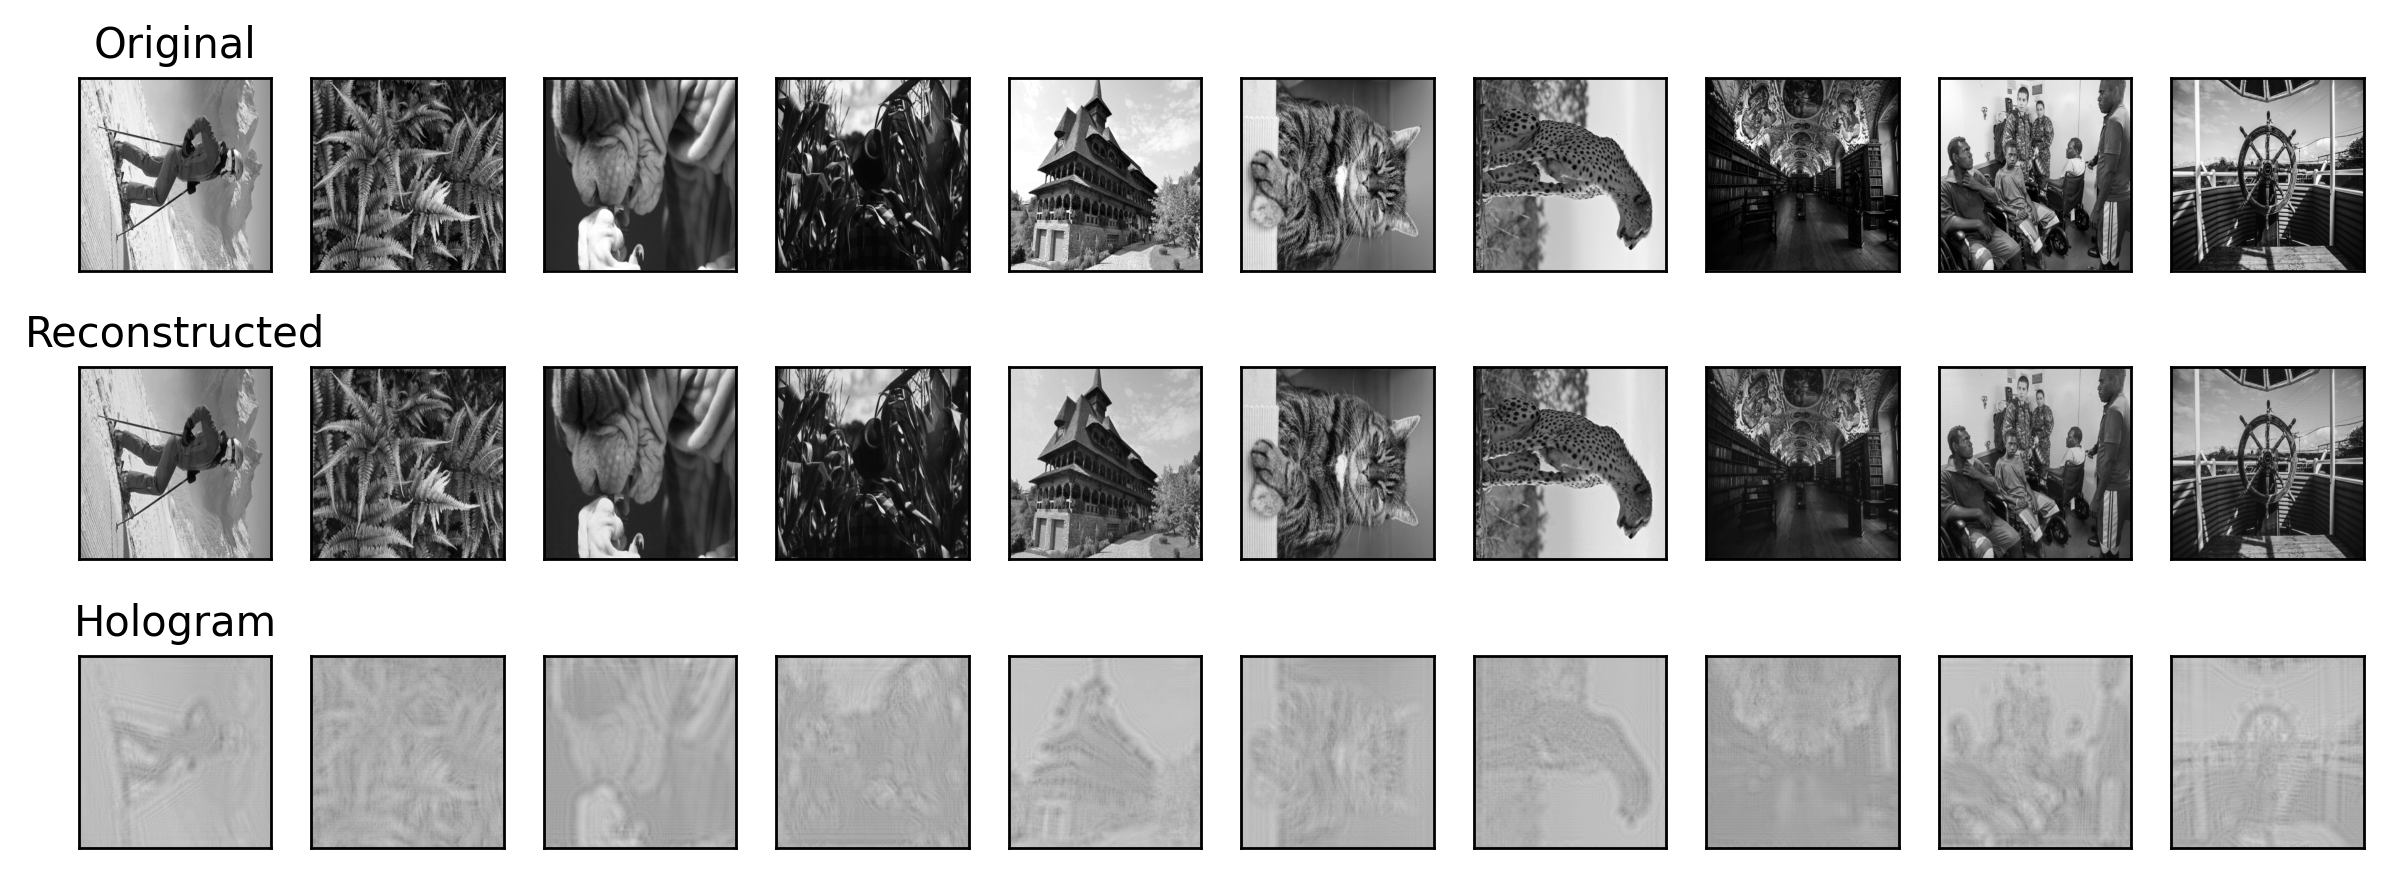

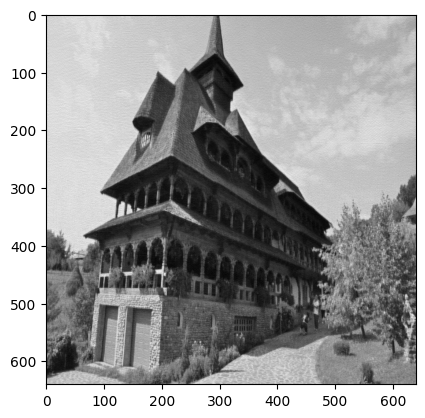

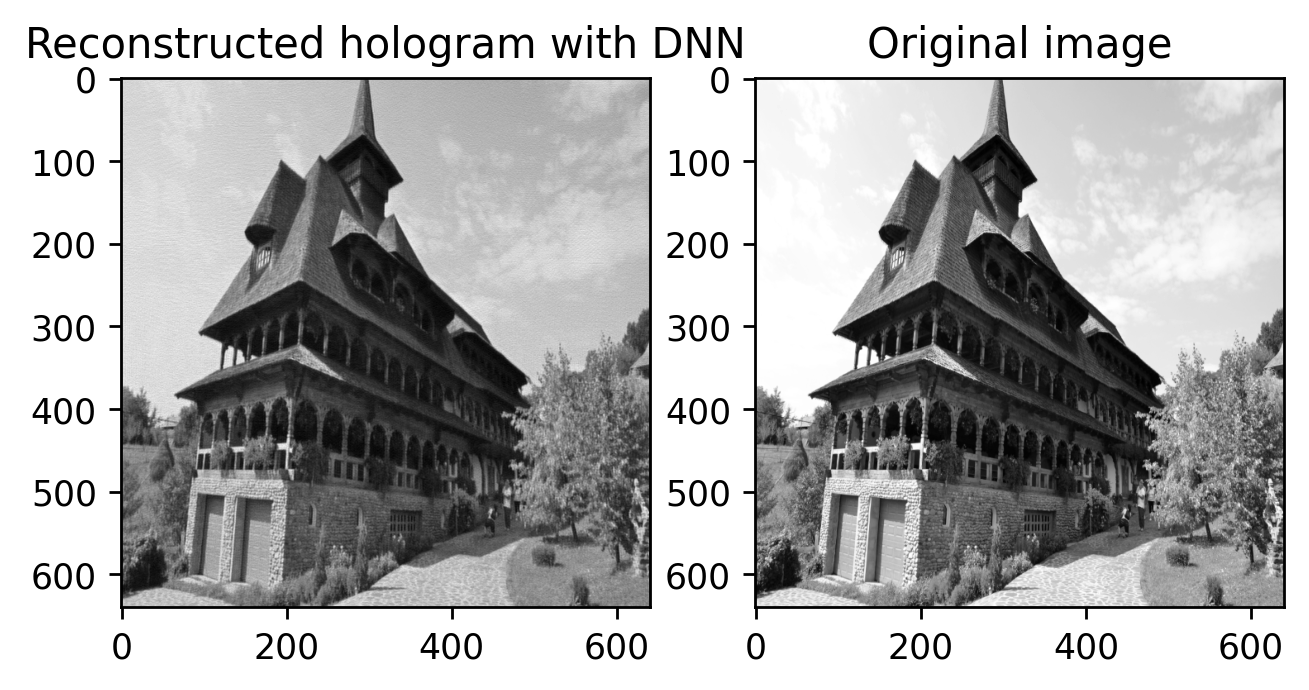

In [15]:
ort_session.end_profiling()#stop onnx profiling
n = 11
plt.figure(figsize=(n+2, 4), dpi=250)
plt.subplots_adjust(hspace=0.5)
input=tf.cast(input,dtype='float32')
for i in range(1, n):#1 to n-1
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(input[i-1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==1:
        ax.set_title("Original")  # Set a title for this subplot
    # Display reconstructed image
    ax = plt.subplot(3, n, i + n)
    plt.imshow(output[i-1])  # Reconstructed one
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==1:
        ax.set_title("Reconstructed")  # Set a title for this subplot
    # Display hologram
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(holo[i-1])  # Reconstructed one
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==1:
        ax.set_title("Hologram")  # Set a title for this subplot
plt.show()


num=25
plt.imshow(output[num-21],cmap='gray')
plt.figure(figsize=(6, 5),dpi=250)
# Subplot 1: Reconstructed hologram
plt.subplot(1, 2, 1)
plt.imshow(output[num-21],cmap='gray')# tf.math.log(tf.abs(D)) for good visualization
plt.title('Reconstructed hologram with DNN')
plt.axis('image')
# Subplot 2: Original image
plt.subplot(1, 2, 2)
plt.imshow(tf.cast(input[num-21],dtype="float32"), cmap='gray')
plt.title('Original image')
plt.axis('image')
plt.show()

output2 = (output - K.min(output)) / (K.max(output) - K.min(output))
#np.save('C:/Users/Unknown/Documents/VSCode/Jupyter/DNN_output.npy',output2.numpy())

In [44]:
#list them for comparison
def NPCC(y_true, y_pred):#NPCC only
    if y_pred.shape[-1] != 1:
        y_pred = tf.expand_dims(y_pred, axis=-1)
    if y_true.shape[0] != y_pred.shape[0]:
        y_true = tf.expand_dims(y_true, axis=0)
    y_true = (y_true - K.min(y_true)) / (K.max(y_true) - K.min(y_true))
    y_pred = (y_pred - K.min(y_pred)) / (K.max(y_pred) - K.min(y_pred))
    y_true=tf.cast(y_true,dtype='float32')
    y_pred=tf.cast(y_pred,dtype='float32')
    # Reshape the 2D images into 1D tensors
    image1_1d = tf.reshape(y_true, [-1])
    image2_1d = tf.reshape(y_pred, [-1])
    # Calculate the means of the images
    mean_image1 = tf.reduce_mean(image1_1d)
    mean_image2 = tf.reduce_mean(image2_1d)
    # Calculate the covariance between the two images
    covariance = tf.reduce_mean((image1_1d - mean_image1) * (image2_1d - mean_image2))
    # Calculate the standard deviations of the images
    stddev_image1 = tf.sqrt(tf.reduce_mean(tf.square(image1_1d - mean_image1)))
    stddev_image2 = tf.sqrt(tf.reduce_mean(tf.square(image2_1d - mean_image2)))
    # Calculate the Pearson correlation coefficient between the two images
    pearson_coefficient_loss = 1 - (covariance / (stddev_image1 * stddev_image2)) #NPCC=-1 is the best, it will converge to 0
    return pearson_coefficient_loss

npcc_losses=[]
kernel = np.array([
        [-1, -1, -1],
        [-1,  15, -1],
        [-1, -1, -1]
    ])*2
for i in range(10):
    inim=input[i].numpy()
    ouim=output[i].numpy()
    #inim = cv2.filter2D(inim, -1, kernel)
    #ouim = cv2.filter2D(ouim, -1, kernel)
    npcc=NPCC(inim,ouim)
    npcc=npcc.numpy()
    npcc_losses.append(npcc)
# Print numeric values vertically
for value in npcc_losses:
    print(str(value))

0.0031690598
0.007648051
0.00087070465
0.0021432042
0.0034222007
0.007296145
0.0015820265
0.006793618
0.0023050904
0.0032625794
